In [25]:
import numpy as np
import sys
from casadi import *

# Add do_mpc to path. This is not necessary if it was installed via pip
sys.path.append('../../../')

# Import do_mpc package:
import do_mpc

In [26]:
model_type = 'continuous' # either 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)

In [27]:
m = 1.47
g = 9.81

In [28]:
fts = ['1', 'x0', 'x1', 'x0^2', 'x0 x1', 'x1^2', 'x0^3', 'x0^2 x1',
       'x0 x1^2', 'x1^3', 'x0^4', 'x0^3 x1', 'x0^2 x1^2', 'x0 x1^3',
       'x1^4']
fts = [ft.replace('x0','height').replace('x1','dheight').replace('^','**').replace(" ", "*") for ft in fts]
params = [1.82166091e+00, -4.65976521e+00,  1.46974913e-01,  4.60556123e+00,
       -1.83923281e-01, -8.40786419e-02, -1.87475213e+00,  1.46835497e-01,
        1.34657857e-01, -3.04364247e-02,  2.67099011e-01, -2.87760760e-02,
       -3.69911037e-02,  3.23100900e-03, -7.58783219e-04]
terms = [str(c)+"*"+ft for c, ft in zip(params, fts)]
eqn = ' + '.join(terms)

In [29]:
height = model.set_variable('_x', 'height')
dheight = model.set_variable('_x', 'dheight')
u = model.set_variable('_u', 'force')
ddheight = model.set_variable('_z', 'ddheight')

model.set_rhs('height', dheight)
model.set_rhs('dheight', ddheight)

newton = (m*ddheight + m*g - u - eval(eqn))

model.set_alg('newton', newton)

In [30]:
E_kin = 1 / 2 * m * dheight**2
E_pot = m * g * height
model.set_expression('E_kin', E_kin)
model.set_expression('E_pot', E_pot)

SX((14.4207*height))

In [31]:
model.setup()

In [32]:
mpc = do_mpc.controller.MPC(model)

In [33]:
setup_mpc = {
    'n_horizon': 100,
    'n_robust': 0,
    'open_loop': 0,
    't_step': 1e-2,
    'state_discretization': 'collocation',
    'collocation_type': 'radau',
    'collocation_deg': 3,
    'collocation_ni': 1,
    'store_full_solution': True,
    # Use MA27 linear solver in ipopt for faster calculations:
    'nlpsol_opts': {'ipopt.linear_solver': 'mumps'}
}
mpc.set_param(**setup_mpc)

In [34]:
mterm = model.aux['E_kin'] + model.aux['E_pot']
lterm = model.aux['E_kin'] + model.aux['E_pot']
mpc.set_objective(mterm=mterm, lterm=lterm)

mpc.set_rterm(force=0.1)

In [35]:
mpc.bounds['lower','_u','force'] = 0
mpc.bounds['upper','_u','force'] = 50
mpc.bounds['lower','_x','height'] = 0

mpc.setup()

In [36]:
estimator = do_mpc.estimator.StateFeedback(model)

In [37]:
simulator = do_mpc.simulator.Simulator(model)

In [38]:
params_simulator = {
    # Note: cvode doesn't support DAE systems.
    'integration_tool': 'idas',
    'abstol': 1e-10,
    'reltol': 1e-10,
    't_step': 0.01
}
simulator.set_param(**params_simulator)

In [39]:
simulator.setup()


In [40]:
simulator.x0['height'] = 0.09 + 1.5
simulator.x0['dheight'] = 0

x0 = simulator.x0.cat.full()

mpc.x0 = x0
estimator.x0 = x0

mpc.set_initial_guess()

In [41]:
n_steps = 1
for k in range(n_steps):
    u0 = mpc.make_step(x0)
    y_next = simulator.make_step(u0)
    x0 = estimator.make_step(y_next)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     5402
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1400

Total number of variables............................:     1510
                     variables with only lower bounds:      496
                variables with lower and upper bounds:      100
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1402
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

In [42]:
import matplotlib.pyplot as plt
plt.ion()
from matplotlib import rcParams
rcParams['text.usetex'] = False
rcParams['axes.grid'] = True
rcParams['lines.linewidth'] = 2.0
rcParams['axes.labelsize'] = 'xx-large'
rcParams['xtick.labelsize'] = 'xx-large'
rcParams['ytick.labelsize'] = 'xx-large'

In [43]:
mpc_graphics = do_mpc.graphics.Graphics(mpc.data)

In [44]:
%%capture

fig = plt.figure(figsize=(16,9))

ax1 = plt.subplot2grid((4, 2), (0, 0), rowspan=4)
ax2 = plt.subplot2grid((4, 2), (0, 1))
ax3 = plt.subplot2grid((4, 2), (1, 1))
ax4 = plt.subplot2grid((4, 2), (2, 1))
ax5 = plt.subplot2grid((4, 2), (3, 1))

ax2.set_ylabel('$E_{kin}$ [J]')
ax3.set_ylabel('$E_{pot}$ [J]')
ax4.set_ylabel('Height [m]')
ax5.set_ylabel('Input force [N]')

# Axis on the right.
for ax in [ax2, ax3, ax4, ax5]:
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    if ax != ax5:
        ax.xaxis.set_ticklabels([])

ax5.set_xlabel('time [s]')

mpc_graphics.add_line(var_type='_aux', var_name='E_kin', axis=ax2)
mpc_graphics.add_line(var_type='_aux', var_name='E_pot', axis=ax3)
mpc_graphics.add_line(var_type='_x', var_name='height', axis=ax4)
mpc_graphics.add_line(var_type='_u', var_name='force', axis=ax5)

# ax1.axhline(0,color='black')

bar1 = ax1.plot([],[], '-o', linewidth=5, markersize=10)
bar2 = ax1.plot([],[], '-o', linewidth=5, markersize=10)

ax1.set_xlim(-1.8,1.8)
ax1.set_ylim(-1.2,1.2)
ax1.set_axis_off()

fig.align_ylabels()
fig.tight_layout()

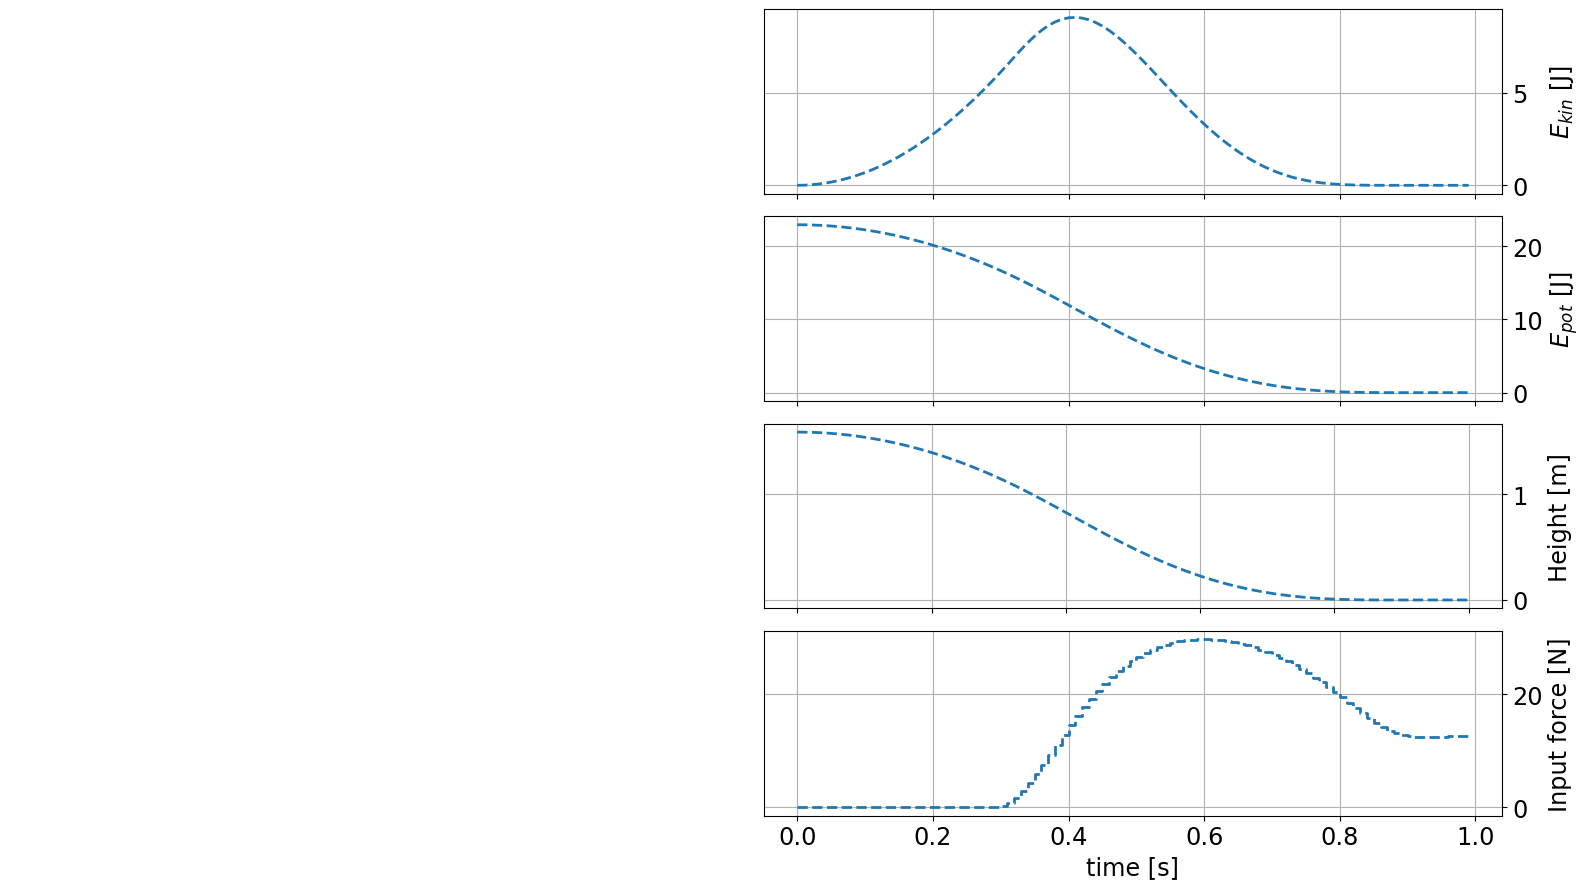

In [45]:
mpc_graphics.plot_predictions()
mpc_graphics.reset_axes()

fig

In [46]:
mpc.data['_u'][0,0]

0.0